In [1]:
import dask.dataframe as pd

In [2]:
!ls data_dpg_testdata/reduced/ 

mapping_article_files.json
mapping_city.json
mapping_geo.json
mapping_refferer.json
mapping_view_files.json
reduced_articles.csv
reduced_articles_df_article.csv
reduced_articles_df_external_categories.csv
reduced_articles_df_external_entities.csv
reduced_articles_df_external_topics.csv
reduced_articles_df_fixed_set_sensitive.csv
reduced_articles_df_fixed_set_topics.csv
reduced_articles_df_fixed_set_userneeds.csv
reduced_articles_df_internal_topics.csv
reduced_interactions-part-00000-d667af8c-fe5d-4c75-b144-400a5560425d-c000.json.csv
reduced_interactions.csv
reduced_views-part-00000-d667af8c-fe5d-4c75-b144-400a5560425d-c000.json.csv
reduced_views.csv


In [22]:
DATA_FOLDER = "preflight"

In [115]:
ddf = pd.read_csv(f'data_dpg_testdata/{DATA_FOLDER}/reduced_views.csv', dtype={'GEO_ZIPCODE': object,
       'REFR_MEDIUM': object, 'IS_LOGGED_IN': object, 'file_name': object,
"privacy_advertising":int,       
"privacy_analytics":int,       
"privacy_functional":int,       
"privacy_geo_location":int,       
"privacy_marketing":int,       
"privacy_non-personalised_ads":int,       
"privacy_personalisation":int,       
"privacy_social_media":int,       
"privacy_target_advertising":int,       
       
       })
ddf["DERIVED_TSTAMP"] = pd.to_datetime(ddf["DERIVED_TSTAMP"])
ddf["hour"] = ddf["DERIVED_TSTAMP"].dt.hour
ddf.tail()

,APP_ID,ARTICLE_ID,DERIVED_TSTAMP,GEO_CITY,GEO_COUNTRY,GEO_ZIPCODE,REFR_MEDIUM,REFR_URLHOST,QUASI_USER_ID,IS_LOGGED_IN,...,privacy_analytics,privacy_target_advertising,privacy_personalisation,privacy_non-personalised_ads,privacy_marketing,privacy_social_media,privacy_geo_location,privacy_advertising,file_name,hour
605375,nu.web,6226963,2022-09-30 07:48:53.069000+00:00,43,NL,4003,internal,1,d9fabacac89e673546bdff0f8a362d68,0,...,1,0,1,1,1,1,0,1,182,7
605376,nu.web,6227080,2022-09-30 12:18:19.374000+00:00,7,NL,1054,internal,1,9e2c7e666fe6929a84ba65105520223b,0,...,1,0,1,1,1,1,0,1,182,12
605377,nu.web,6227005,2022-09-30 08:28:02.949000+00:00,25,NL,3526,internal,1,3081ecc18275db8b0df78bbc7ca29f17,0,...,1,0,1,1,1,1,0,1,182,8
605378,nu.web,6227005,2022-09-30 09:52:44.873000+00:00,201,NL,4631,internal,1,945f03c291ab39908a709d209c391e55,0,...,1,0,1,1,1,1,0,1,182,9
605379,nu.web,6227014,2022-09-30 12:32:19.555000+00:00,59,NL,1223,search,11,a960405a850a8cef6402f025d9098aa3,0,...,1,0,1,1,1,1,0,1,182,12


In [29]:
ddf.groupby(['REFR_URLHOST'])['APP_ID'].count().compute()

REFR_URLHOST
1       522406
2        27100
3        33951
4         6884
5      1141214
        ...   
421          1
422          1
423          1
424          1
425          1
Name: APP_ID, Length: 424, dtype: int64

In [89]:
DATA_FOLDER_ARTICLES = "reduced"
ddf2 = pd.read_csv(f'data_dpg_testdata/{DATA_FOLDER_ARTICLES}/reduced_articles_df_article.csv', dtype={'sub_section': 'object',
       'url': 'object'})
ddf2.head()

,article_id,cds_content_id,brands,title,text,authors,url,main_section,sub_section,num_words,num_sentences,num_chars,first_publication_timestamp,categories_generated,keywords_curated,brand_safety_is_brandsafe,brand_safety_confidence,file_name
0,6178608,article-mm-61e525b134c4a700014017f7,nu.nl,Unilever geeft strijd om overname Aquafresh-ma...,Unilever stelt maandag in een verklaring dat d...,NU.nl/ANP,https://nu.nl/economie/6178608/unilever-geeft-...,Economie,NaN,0,0,0,NaN,Economie,Economie|Unilever|GSK,True,0.1,0
1,6178610,article-mm-61e5302d6ae9490001e6d524,nu.nl,"Had de metro één meter verder gereden, dan was...",_Dit artikel is afkomstig uit HLN. Elke dag ve...,HLN/Jeffrey Dujardin en Robby Dierickx,https://nu.nl/uit-andere-media/6178610/had-de-...,Uit andere media,NaN,0,0,0,NaN,Uit andere media,NaN,True,0.1,0
2,6178739,article-mm-61e5b36154be560001ebf681,nu.nl,Stalker van Kylie Jenner krijgt permanent cont...,De man kreeg vorig jaar al een tijdelijk conta...,NU.nl/ANP,https://nu.nl/achterklap/6178739/stalker-van-k...,Achterklap,NaN,0,0,0,NaN,Achterklap,Kylie Jenner|Achterklap,True,0.1,0
3,6178681,article-mm-61e570a560f2eb0001784c84,nu.nl,Karatsev na bijna 5 uur en 107 onnodige fouten...,De krachtmeting op Melbourne Park duurde om pr...,NU.nl,https://nu.nl/sport/6178681/karatsev-na-bijna-...,Sport,NaN,0,0,0,NaN,Sport|Tennis|Sport Overig,Aslan Karatsev|Australian Open|Tennis,True,0.1,0
4,6178734,article-mm-61e5ac5d3637950001c51671,nu.nl,Lees alles over de tweede award op rij voor Le...,NaN,NU.nl,https://nu.nl/sport/6178734/lees-alles-over-de...,Sport,NaN,0,0,0,NaN,Voetbal|Sport,FIFA-gala,True,0.1,0


In [90]:
ddf2.loc[ddf2["num_sentences"] != 0].compute().head()

,article_id,cds_content_id,brands,title,text,authors,url,main_section,sub_section,num_words,num_sentences,num_chars,first_publication_timestamp,categories_generated,keywords_curated,brand_safety_is_brandsafe,brand_safety_confidence,file_name
138,6181257,article-mm-61f7ce39adc7c500015b6220,nu.nl,Documentaire onthult onderzoek naar vader Máxi...,Zorreguieta diende vijf jaar in de regering ti...,NU.nl,https://nu.nl/algemeen/6181257/documentaire-on...,Media en Cultuur,Koningshuis,481,23,3120,NaN,Media|Koningshuis|Media en Cultuur|Algemeen,Koningin Máxima|Koningshuis|Media|Koning Wille...,True,0.1,0
139,6181210,article-mm-61f7a400b9043c0001ab87c0,nu.nl,"Corrie nu officieel een storm, schade en vertr...",Op verschillende plekken in het land zijn wege...,NU.nl/ANP,https://nu.nl/algemeen/6181210/corrie-nu-offic...,Algemeen,Binnenland,391,41,2636,NaN,Algemeen|Binnenland,Weer|Binnenland,True,0.1,0
141,6179036,article-mm-61e845f2b0cdd60001e17c0f,nu.nl,Nederland met recordaantal sporters naar Olymp...,Sportkoepel NOC*NSF gaf snowboardster Michelle...,Daan de Ridder,https://nu.nl/algemeen/6179036/nederland-met-r...,Olympische Spelen,Olympische Spelen,256,17,1722,NaN,Algemeen|Olympische Spelen|Sport|Sport Overig,Olympische Spelen,True,0.1,0
142,6181293,article-mm-61f7f02f0ad3d9000122fadb,nu.nl,"Handel rond Chinees Nieuwjaar trekt iets aan, ...",Met twee groothandels en 24 gespecialiseerde s...,NU.nl,https://nu.nl/economie/6181293/handel-rond-chi...,Economie,Economie,303,23,1827,NaN,Economie,Economie,True,0.1,0
143,6181350,article-mm-61f822823c63720001797716,nu.nl,Ajax komt er niet uit met Tottenham en ziet af...,Volgens [_De Telegraaf_](https://www.telegraaf...,NU.nl,https://nu.nl/sport/6181350/ajax-komt-er-niet-...,Sport,Voetbal,323,20,2138,NaN,Voetbal|Sport,Steven Bergwijn|Ajax|Voetbal,True,0.1,0


In [116]:
ddf3 = ddf2[["article_id", "num_words", "num_sentences", "num_chars"]].merge(ddf[["ARTICLE_ID", "APP_ID"]], left_on='article_id', right_on='ARTICLE_ID')
ddf4 = ddf3[["APP_ID", "num_words", "num_sentences", "num_chars"]].loc[ddf3["num_chars"] > 0]
ddf4.groupby("APP_ID").agg(["mean", "std"]).compute()

num_words             num_sentences             \
                          mean         std          mean        std   
APP_ID                                                                
nu.android          362.017792  230.695588     26.223305  16.121058   
nu.ios              362.516603  236.724373     26.433012  16.723708   
nu.web              357.647029  230.679056     26.220175  16.154011   
nu.web.advertorial   37.000000         NaN      3.000000        NaN   

                      num_chars               
                           mean          std  
APP_ID                                        
nu.android          2313.607452  1474.576900  
nu.ios              2319.677977  1512.982143  
nu.web              2293.757863  1479.820862  
nu.web.advertorial   247.000000          NaN

In [92]:
factor_1 = ddf4.loc[ddf4["APP_ID"] == "nu.android", "num_words"].compute()
factor_2 = ddf4.loc[ddf4["APP_ID"] == "nu.web", "num_words"].compute()
factor_3 = ddf4.loc[ddf4["APP_ID"] == "nu.ios", "num_words"].compute()

In [93]:
import scipy.stats as stats
fvalue, pvalue = stats.f_oneway(factor_1, factor_2, factor_3)
fvalue, pvalue

(80.36762544521369, 1.2546032995147558e-35)

In [94]:
# https://www.reneshbedre.com/blog/anova.html

# get ANOVA table as R like output
import statsmodels.api as sm
from statsmodels.formula.api import ols

df_melt = pd.melt(ddf4, id_vars=['APP_ID'], value_vars=["num_words", "num_sentences", "num_chars"]).compute()
df_melt.head()

,APP_ID,variable,value
0,nu.web,num_words,127
1,nu.android,num_words,211
2,nu.web,num_words,131
3,nu.android,num_words,123
4,nu.web,num_words,262


In [95]:
# Ordinary Least Squares (OLS) model
model = ols('value ~ C(APP_ID)', data=df_melt.loc[df_melt["variable"] == "num_chars"]).fit()
anova_table = sm.stats.anova_lm(model, typ=2)
anova_table

,sum_sq,df,F,PR(>F)
C(APP_ID),2.303764e+08,3.0,34.600012,2.371248e-22
Residual,3.613714e+12,1628221.0,NaN,NaN


In [168]:
import pingouin as pg
pg.kruskal(data=df_melt.loc[df_melt["variable"] == "num_words"], dv='value', between='APP_ID')

,Source,ddof1,H,p-unc
Kruskal,APP_ID,3,304.221329,1.213761e-65


In [96]:
# Ordinary Least Squares (OLS) model
model = ols('value ~ C(APP_ID)', data=df_melt.loc[df_melt["variable"] == "num_words"]).fit()
anova_table = sm.stats.anova_lm(model, typ=2)
anova_table

,sum_sq,df,F,PR(>F)
C(APP_ID),8.810238e+06,3.0,54.221795,4.893690e-35
Residual,8.818726e+10,1628221.0,NaN,NaN


In [97]:
# Ordinary Least Squares (OLS) model
model = ols('value ~ C(APP_ID)', data=df_melt.loc[df_melt["variable"] == "num_sentences"]).fit()
anova_table = sm.stats.anova_lm(model, typ=2)
anova_table

,sum_sq,df,F,PR(>F)
C(APP_ID),1.680703e+04,3.0,20.984501,1.374890e-13
Residual,4.346949e+08,1628221.0,NaN,NaN


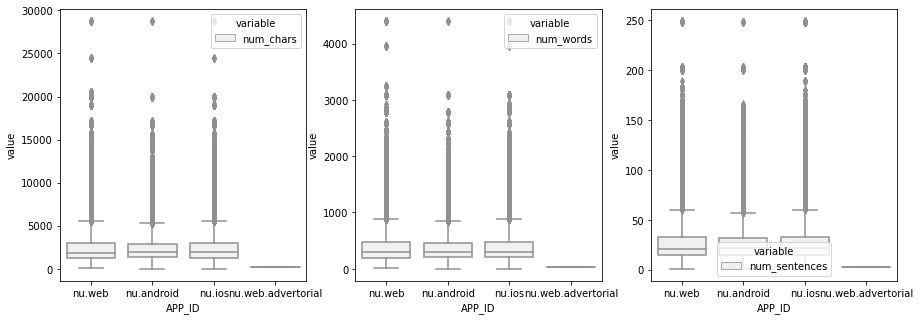

In [101]:
# generate a boxplot to see the data distribution by treatments. Using boxplot, we can 
# easily detect the differences between different treatments
import matplotlib.pyplot as plt
import seaborn as sns
fig, axes= plt.subplots(1, 3, figsize=(15, 5))
with_outliers = True
ax0 = sns.boxplot(x='APP_ID', y='value', data=df_melt.loc[df_melt["variable"] == "num_chars"], color='#99c2a2', hue="variable", ax=axes[0], showfliers = with_outliers)
ax1 = sns.boxplot(x='APP_ID', y='value', data=df_melt.loc[df_melt["variable"] == "num_words"], color='#99c2a2', hue="variable", ax=axes[1], showfliers = with_outliers)
ax2 = sns.boxplot(x='APP_ID', y='value', data=df_melt.loc[df_melt["variable"] == "num_sentences"], color='#99c2a2', hue="variable", ax=axes[2], showfliers = with_outliers)
plt.show()

In [113]:

ddf.head()

,APP_ID,ARTICLE_ID,DERIVED_TSTAMP,GEO_CITY,GEO_COUNTRY,GEO_ZIPCODE,REFR_MEDIUM,REFR_URLHOST,QUASI_USER_ID,IS_LOGGED_IN,...,privacy_analytics,privacy_target_advertising,privacy_personalisation,privacy_non-personalised_ads,privacy_marketing,privacy_social_media,privacy_geo_location,privacy_advertising,file_name,hour
0,nu.web,6192514,2022-04-01 07:08:22.118000+00:00,1,NL,5342,internal,1,6f41dac40d31dcb9c02e8b59b26b5a25,1,...,1,0,1,1,1,1,0,1,0,7
1,nu.web,6192636,2022-04-01 07:07:45.703000+00:00,2,NL,5038,internal,1,a598d85bd238f7263c0e2c1ba88f02e3,1,...,1,0,1,1,1,1,0,1,0,7
2,nu.web,6192559,2022-04-01 07:16:48.266000+00:00,3,NL,8857,search,2,244a7ae3756d1061519957b81a49d0ef,1,...,1,0,1,1,1,1,0,1,0,7
3,nu.web,6192670,2022-04-01 07:16:22.336000+00:00,4,NL,5061,search,2,ef4d56a993d4977f4d605ab0354864d5,1,...,1,0,1,1,1,1,0,1,0,7
4,nu.web,6192674,2022-04-01 07:17:06.217000+00:00,5,NL,2291,internal,1,23f702616f1f1425b18211a0cd689ff4,1,...,1,0,1,1,1,1,0,1,0,7


In [123]:
ddf3 = ddf2[["article_id"]].merge(ddf[["ARTICLE_ID", "APP_ID", "hour"]], left_on='article_id', right_on='ARTICLE_ID')
ddf3.head()

,article_id,ARTICLE_ID,APP_ID,hour
0,6178585,6178585,nu.android,8
1,6178596,6178596,nu.web,4
2,6178474,6178474,nu.web,10
3,6178626,6178626,nu.android,18
4,6178697,6178697,nu.ios,4


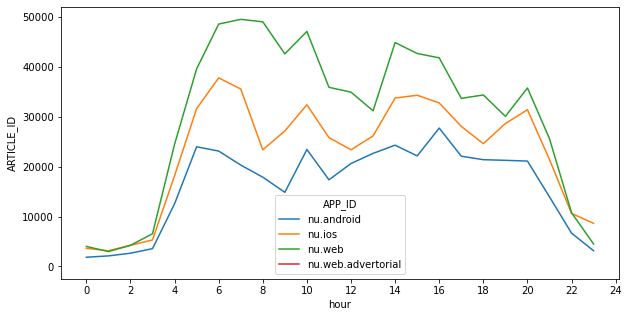

In [131]:
import numpy as np
stepsize = 2
fig = plt.figure(figsize=(10, 5))
ax = sns.lineplot(x="hour", y="ARTICLE_ID", hue="APP_ID" ,data=ddf3.groupby(["APP_ID", "hour"]).count().reset_index().compute())
ax.xaxis.set_ticks(np.arange(0, 26, stepsize))
plt.show()

In [133]:
ddf_topics = pd.read_csv(f'data_dpg_testdata/{DATA_FOLDER_ARTICLES}/reduced_articles_df_fixed_set_topics.csv', dtype={'sub_section': 'object',
       'url': 'object'})
ddf_topics.head()

,article_id,topic_voetbal,topic_optredens_en_voorstellingen,topic_politiek,topic_technologie_en_handel,topic_relatie_en_opvoeden,topic_bestuur_en_organisatie,topic_human_interest,topic_verkeersongevallen,topic_nominatie_en_prijzen,...,topic_afval_en_milieuproblematiek,topic_consumeren_en_vrije_tijd,topic_overheidsbeleid,topic_vakbond_club_en_vereniging,topic_religie,topic_bouwen_en_wonen,topic_recht_en_justitie,topic_samenleving,topic_woon_en_leefomgeving,file_name
0,6178608,0.043142,0.001140,0.000977,0.085372,0.002397,0.001183,0.001791,0.000650,0.000829,...,0.000595,0.001431,0.130365,0.030968,0.000838,0.000758,0.000944,0.000691,0.019378,0
1,6178610,0.000512,0.000453,0.025080,0.000563,0.048403,0.022881,0.205593,0.124505,0.000328,...,0.013110,0.011960,0.000514,0.007522,0.000332,0.000300,0.087054,0.000274,0.035372,0
2,6178739,0.003579,0.003158,0.002706,0.003929,0.159745,0.003275,0.185203,0.001801,0.002296,...,0.001649,0.003948,0.003594,0.029818,0.002322,0.002099,0.002614,0.095430,0.006187,0
3,6178681,0.439941,0.049329,0.001649,0.002393,0.004043,0.001995,0.003003,0.001097,0.087265,...,0.001005,0.002409,0.037873,0.042356,0.030830,0.001279,0.001592,0.001167,0.003778,0
4,6178734,0.018255,0.016113,0.013809,0.020110,0.033269,0.016706,0.025336,0.009188,0.185835,...,0.008414,0.020164,0.018353,0.009997,0.011844,0.010708,0.013332,0.009771,0.264851,0


In [149]:
ddf_topics_merged = ddf_topics.merge(ddf[["ARTICLE_ID", "APP_ID"]], left_on='article_id', right_on='ARTICLE_ID')
ddf_topics_merged.head()

,article_id,topic_voetbal,topic_optredens_en_voorstellingen,topic_politiek,topic_technologie_en_handel,topic_relatie_en_opvoeden,topic_bestuur_en_organisatie,topic_human_interest,topic_verkeersongevallen,topic_nominatie_en_prijzen,...,topic_overheidsbeleid,topic_vakbond_club_en_vereniging,topic_religie,topic_bouwen_en_wonen,topic_recht_en_justitie,topic_samenleving,topic_woon_en_leefomgeving,file_name,ARTICLE_ID,APP_ID
0,6178585,0.001042,0.010346,0.024450,0.001147,0.047064,0.058175,0.001432,0.000524,0.017471,...,0.257748,0.000570,0.000676,0.000611,0.000761,0.009473,0.089847,0,6178585,nu.android
1,6178596,0.019135,0.000737,0.000631,0.000917,0.029128,0.000764,0.001152,0.000420,0.000535,...,0.069096,0.033835,0.000541,0.000489,0.000609,0.065990,0.001487,0,6178596,nu.web
2,6178474,0.000733,0.000648,0.000554,0.025530,0.001414,0.000671,0.001017,0.000369,0.000470,...,0.170609,0.007125,0.000476,0.038300,0.000535,0.012012,0.155184,0,6178474,nu.web
3,6178626,0.010736,0.000963,0.000826,0.021695,0.130691,0.088184,0.001507,0.000549,0.000700,...,0.112890,0.000598,0.000708,0.000640,0.256412,0.100560,0.001920,0,6178626,nu.android
4,6178697,0.002212,0.001953,0.083020,0.002430,0.004146,0.002026,0.003050,0.001113,0.001419,...,0.159446,0.001211,0.001435,0.001298,0.171009,0.001184,0.003904,0,6178697,nu.ios


In [142]:
topic_columns = ddf_topics_merged.columns[ddf_topics_merged.columns.str.startswith("topic_")]
topic_columns

Index(['topic_voetbal', 'topic_optredens_en_voorstellingen', 'topic_politiek',
       'topic_technologie_en_handel', 'topic_relatie_en_opvoeden',
       'topic_bestuur_en_organisatie', 'topic_human_interest',
       'topic_verkeersongevallen', 'topic_nominatie_en_prijzen',
       'topic_veiligheid', 'topic_onderwijs',
       'topic_maatschappelijke_instellingen', 'topic_economie',
       'topic_lokale_evenementen', 'topic_het_weer', 'topic_brand',
       'topic_verkeer', 'topic_gezondheid_en_zorg', 'topic_gemeentepolitiek',
       'topic_sport', 'topic_kunst_en_cultuur', 'topic_eten_en_drinken',
       'topic_natuur', 'topic_duurzaamheid', 'topic_misdaad',
       'topic_wielrennen', 'topic_zingeving_en_verhalen',
       'topic_afval_en_milieuproblematiek', 'topic_consumeren_en_vrije_tijd',
       'topic_overheidsbeleid', 'topic_vakbond_club_en_vereniging',
       'topic_religie', 'topic_bouwen_en_wonen', 'topic_recht_en_justitie',
       'topic_samenleving', 'topic_woon_en_leefomgeving

In [167]:
# for col in topic_columns:
#     ax = sns.histplot(data=ddf_topics_merged,x=col, hue="APP_ID")
#     ax.set_xlim(0,1)
#     plt.show()
# ddf_topics_merged["max_topic"] = list(np.argmax(ddf_topics_merged[topic_columns].compute().values, axis=1))
# ddf_topics_merged
am_topics = np.argmax(ddf_topics_merged[topic_columns].compute().values, axis=1)
ddf_topics_merged["amt"]=pd.array.from_array(am_topics)
ddf_topics_merged

AttributeError: module 'dask.dataframe' has no attribute 'array'

In [161]:
len(topic_columns)

36